In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# AutoARIMA Model

> Step-by-step guide on using the `AutoARIMA Model` with `Statsforecast`.

The objective of the following article is to obtain a step-by-step guide on building the Arima model using `AutoARIMA` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation`.

The text in this article is largely taken from [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)".](https://otexts.com/fpp3/tscv.html)

## Table of Contents 

* [What is AutoArima with StatsForecast?](#introduction)
* [Definition of the Arima model](#arima)
* [Advantages of using AutoArima](#advantages)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of AutoARIMA with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## What is AutoArima with StatsForecast? <a class="anchor" id="#introduction"></a>

An autoARIMA is a time series model that uses an automatic process to select the optimal ARIMA (Autoregressive Integrated Moving Average) model parameters for a given time series. ARIMA is a widely used statistical model for modeling and predicting time series.

The process of automatic parameter selection in an autoARIMA model is performed using statistical and optimization techniques, such as the Akaike Information Criterion (AIC) and cross-validation, to identify optimal values for autoregression, integration, and moving average parameters. of the ARIMA model.

Automatic parameter selection is useful because it can be difficult to determine the optimal parameters of an ARIMA model for a given time series without a thorough understanding of the underlying stochastic process that generates the time series. The autoARIMA model automates the parameter selection process and can provide a fast and effective solution for time series modeling and forecasting.

The `statsforecast.models` library brings the `AutoARIMA` function from Python provides an implementation of autoARIMA that allows to automatically select the optimal parameters for an ARIMA model given a time series.

## Definition of the Arima model <a class="anchor" id="model"></a>

An Arima model (autoregressive integrated moving average) process is the combination of an autoregressive process AR(p), integration I(d), and the moving average process MA(q).

Just like the ARMA process, the ARIMA process states that the present value is dependent on past values, coming from the AR(p) portion, and past errors, coming from the MA(q) portion. However, instead of using the original series, denoted as yt,
the ARIMA process uses the differenced series, denoted as $y'_{t}$. Note that $y'_{t}$ can represent a series that has been differenced more than once.

Therefore, the mathematical expression of the ARIMA(p,d,q) process states that the present value of the differenced series $y'_{t}$ is equal to the sum of a constant $C$, past values of the differenced series $\phi_{p}y'_{t-p}$, the mean of the differenced series $\mu$, past error terms $\theta_{q}\varepsilon_{t-q}$, and a current error term $\varepsilon_{t}$, as shown in equation 

\begin{equation}
  y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p}
     + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t},  \tag{1}
\end{equation}

where $y'_{t}$ is the differenced series (it may have been differenced more than once). The "predictors" on the right hand side include both lagged values of $y_{t}$ and lagged errors. We call this an **ARIMA( p,d,q)** model, where

|  |  |
|-|-------------------------|
|p|order of the autoregressive part|
|d|degree of first differencing involved|
|q|order of the moving average part|

The same stationarity and invertibility conditions that are used for autoregressive and moving average models also apply to an ARIMA model.

Many of the models we have already discussed are special cases of the ARIMA model, as shown in Table

|Model          |p   d   q |Differenced         |Method|
|---------------|----------|---------------------|--------------|
|Arima(0,0,0)   |0   0   0 |$y_t=Y_t$            |White noise|
|ARIMA (0,1,0)  |0   1   0 |$y_t = Y_t - Y_{t-1}$| Random walk|
|ARIMA (0,2,0)  |0   2   0 |$y_t = Y_t - 2Y_{t-1} + Y_{t-2}$| Constant|
|ARIMA (1,0,0)  |1   0   0 |$\hat Y_t = \mu + \Phi_1 Y_{t-1} + \epsilon$| AR(1): AR(1): First-order regression model|
|ARIMA (2, 0, 0)|2   0   0 |$\hat Y_t = \Phi_0 + \Phi_1 Y_{t-1} + \Phi_2 Y_{t-2} + \epsilon$| AR(2): Second-order regression model|
|ARIMA (1, 1, 0)|1   1   0 |$\hat Y_t = \mu + Y_{t-1} + \Phi_1 (Y_{t-1}- Y_{t-2})$ | Differenced first-order autoregressive model|
|ARIMA (0, 1, 1)|0   1   1 |$\hat Y_t = Y_{t-1} - \Phi_1 e^{t-1}$|Simple exponential smoothing|
|ARIMA (0, 0, 1)|0   0   1 |$\hat Y_t = \mu_0+ \epsilon_t - \omega_1 \epsilon_{t-1}$|MA(1): First-order regression model|
ARIMA (0, 0, 2) |0   0   2 |$\hat Y_t = \mu_0+ \epsilon_t - \omega_1 \epsilon_{t-1} - \omega_2 \epsilon_{t-2}$|MA(2): Second-order regression model|
|ARIMA (1, 0, 1)|1   0   1 |$\hat Y_t = \Phi_0 + \Phi_1 Y_{t-1}+ \epsilon_t - \omega_1 \epsilon_{t-1}$|ARMA model|
|ARIMA (1, 1, 1)|1   1   1 |$\Delta Y_t = \Phi_1 Y_{t-1} + \epsilon_t - \omega_1 \epsilon_{t-1}$ |ARIMA model|
|ARIMA (1, 1, 2)|1   1   2 |$\hat Y_t = Y_{t-1} + \Phi_1 (Y_{t-1} - Y_{t-2} )- \Theta_1 e_{t-1} - \Theta_1 e_{t-1}$ | Damped-trend linear Exponential smoothing|
|ARIMA (0, 2, 1) OR (0,2,2) |0 2 1 |$\hat Y_t = 2 Y_{t-1} - Y_{t-2} - \Theta_1 e_{t-1} - \Theta_2 e_{t-2}$|Linear exponential smoothing|

Once we start combining components in this way to form more complicated models, it is much easier to work with the backshift notation. For example, Equation (1) can be written in backshift notation as:

\begin{equation}
\tag{2}
  \begin{array}{c c c c}
    (1-\phi_1B - \cdots - \phi_p B^p) & (1-B)^d y_{t} &= &c + (1 + \theta_1 B + \cdots + \theta_q B^q)\varepsilon_t\\
    {\uparrow} & {\uparrow} & &{\uparrow}\\
    \text{AR($p$)} & \text{$d$ differences} & & \text{MA($q$)}\\
  \end{array}
\end{equation}

Selecting appropriate values for p, d and q can be difficult. However, the `AutoARIMA()` function from `statsforecast` will do it for you automatically.

For more information [here]("https://otexts.com/fpp3/non-seasonal-arima.html")


## Loading libraries and data <a class="anchor" id="loading"></a>

Using an `AutoARIMA()` model to model and predict time series has several advantages, including:

1. Automation of the parameter selection process: The `AutoARIMA()` function automates the ARIMA model parameter selection process, which can save the user time and effort by eliminating the need to manually try different combinations of parameters.

2. Reduction of prediction error: By automatically selecting optimal parameters, the **ARIMA** model can improve the accuracy of predictions compared to manually selected **ARIMA** models.

3. Identification of complex patterns: The `AutoARIMA()` function can identify complex patterns in the data that may be difficult to detect visually or with other time series modeling techniques.

4. Flexibility in the choice of the parameter selection methodology: The **ARIMA** Model can use different methodologies to select the optimal parameters, such as the Akaike Information Criterion (AIC), cross-validation and others, which allows the user to choose the methodology that best suits their needs.

In general, using the `AutoARIMA()` function can help improve the efficiency and accuracy of time series modeling and forecasting, especially for users who are inexperienced with manual parameter selection for ARIMA models.

### Main results

We compared accuracy and speed against [pmdarima](https://github.com/alkaline-ml/pmdarima), Rob Hyndman's [forecast](https://github.com/robjhyndman/forecast) package and Facebook's [Prophet](https://github.com/facebook/prophet). We used the `Daily`, `Hourly` and `Weekly` data from the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128). 

The following table summarizes the results. As can be seen, our `auto_arima` is the best model in accuracy (measured by the `MASE` loss) and time, even compared with the original implementation in R.

| dataset   | metric   |   auto_arima_nixtla | auto_arima_pmdarima [1] |   auto_arima_r |   prophet |
|:----------|:---------|--------------------:|----------------------:|---------------:|----------:|
| Daily     | MASE     |                **3.26** |                  3.35 |           4.46 |     14.26 |
| Daily     | time     |                **1.41** |                 27.61 |           1.81 |    514.33 |
| Hourly    | MASE     |                **0.92** |                ---    |           1.02 |      1.78 |
| Hourly    | time     |               **12.92** |                ---    |          23.95 |     17.27 |
| Weekly    | MASE     |                **2.34** |                  2.47 |           2.58 |      7.29 |
| Weekly    | time     |                0.42 |                  2.92 |           **0.22** |     19.82 |


[1] The model `auto_arima` from `pmdarima` had a problem with Hourly data. An issue was opened.



The following table summarizes the data details.
 
| group   | n_series   | mean_length   | std_length   |   min_length | max_length   |
|:--------|-----------:|--------------:|-------------:|-------------:|-------------:|
| Daily   | 4,227      | 2,371         | 1,756        |          107 | 9,933        |
| Hourly  | 414        | 901           | 127          |          748 | 1,008        |
| Weekly  | 359        | 1,035         | 707          |           93 | 2,610        | 


## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} 
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation../getting-started/0_Installation). 
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Loading Data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/candy_production.csv")
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1972-01-01,85.6945,1
1,1972-02-01,71.8200,1
2,1972-03-01,66.0229,1
3,1972-04-01,64.5645,1
4,1972-05-01,65.0100,1


In [ ]:
print(df.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


We need to convert `ds` from the `object` type to datetime.

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore data with the plot method <a class="anchor" id="plotting"></a>

Plot a series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

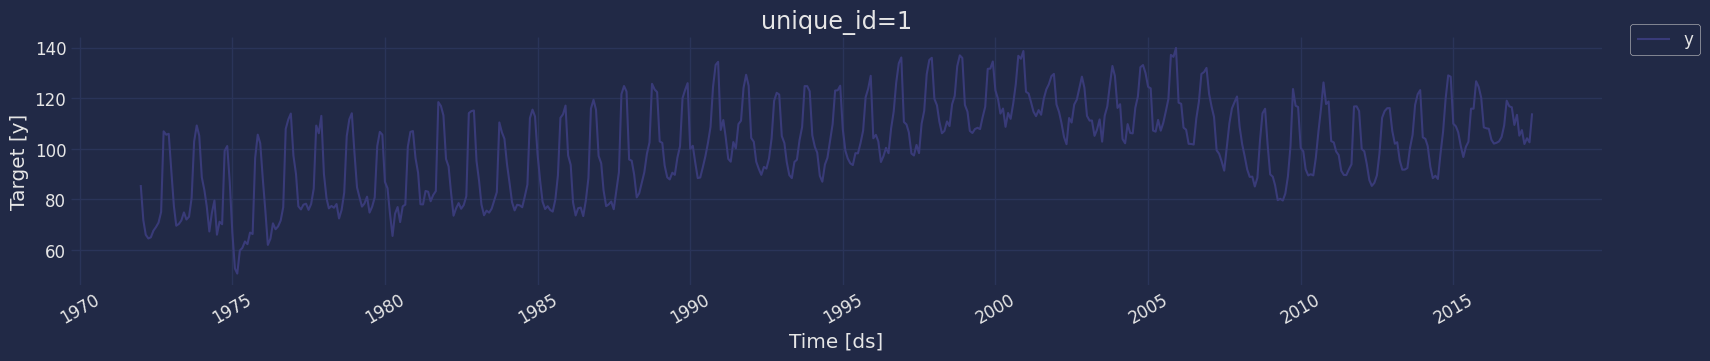

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

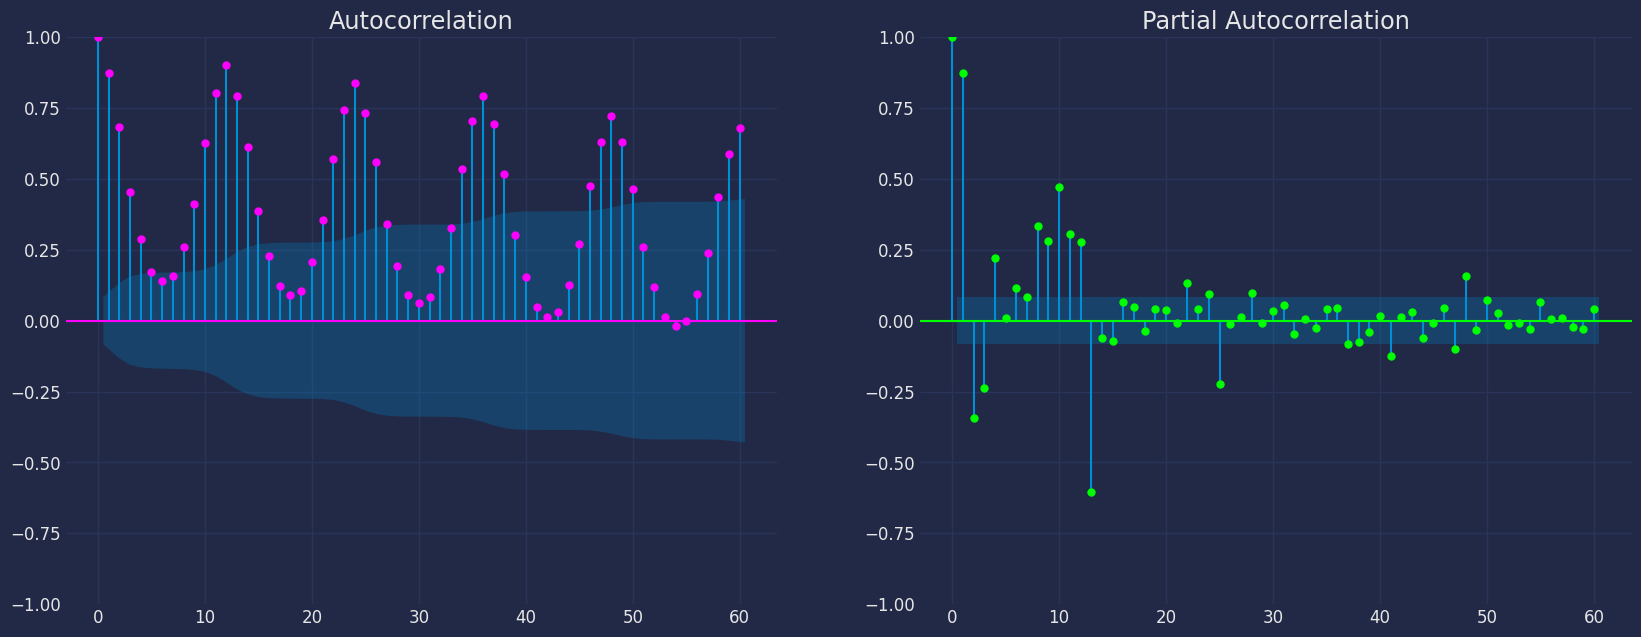

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* multiplicative

Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

## Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

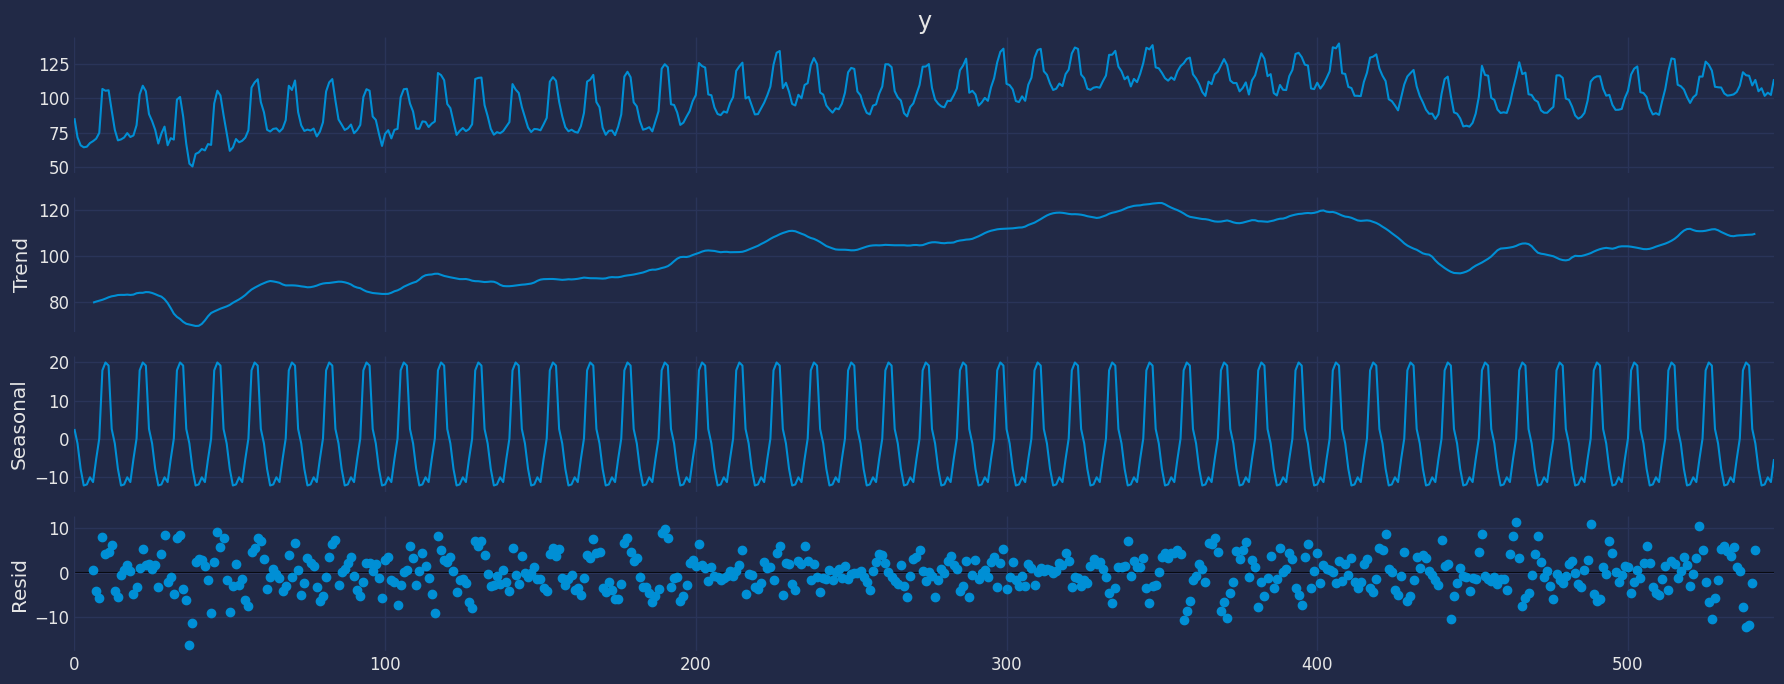

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "add", period=12)
a.plot();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `AutoArima` model
2. Data to test our model

For the test data we will use the last 12 months to test and evaluate the performance of our model.

In [ ]:
Y_train_df = df[df.ds<='2016-08-01']
Y_test_df = df[df.ds>'2016-08-01']

In [ ]:
Y_train_df.shape, Y_test_df.shape

((536, 3), (12, 3))

Now let's plot the training data and the test data.

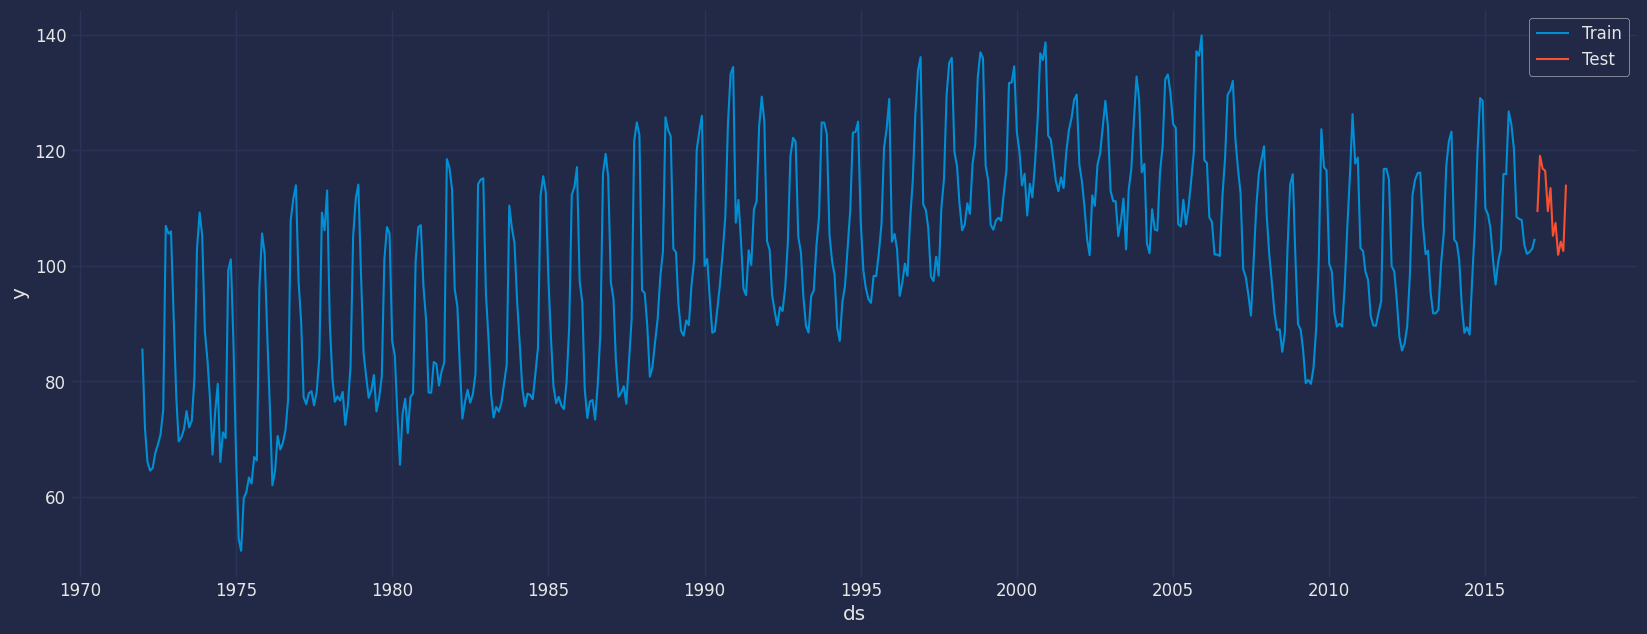

In [ ]:
sns.lineplot(Y_train_df,x="ds", y="y", label="Train")
sns.lineplot(Y_test_df, x="ds", y="y", label="Test")
plt.show()

# Implementation of AutoArima with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

### Instantiating Model
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/)) by the master, Rob Hyndmann, can be useful.season_length

In [ ]:
season_length = 12 # Monthly data
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See panda’s available frequencies.)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='MS')

### Fit the Model

In [ ]:
sf.fit(df=Y_train_df)

StatsForecast(models=[AutoARIMA])

Once we have entered our model, we can use the `arima_string` function to see the parameters that the model has found.

In [ ]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(4,0,3)(0,1,1)[12]                   '

The automation process gave us that the best model found is a model of the form `ARIMA(4,0,3)(0,1,1)[12]`, this means that our model contains $p=4$ , that is, it has a non-seasonal autogressive element, on the other hand, our model contains a seasonal part, which has an order of $D=1$, that is, it has a seasonal differential, and $q=3$ that contains 3 moving average element.

To know the values of the terms of our model, we can use the following statement to know all the result of the model made.

In [ ]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(4, 3, 0, 1, 12, 0, 1)


Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.





In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,0.085694
1,0.071820
2,0.066022
...,...
533,1.615486
534,-0.394285
535,-6.733548


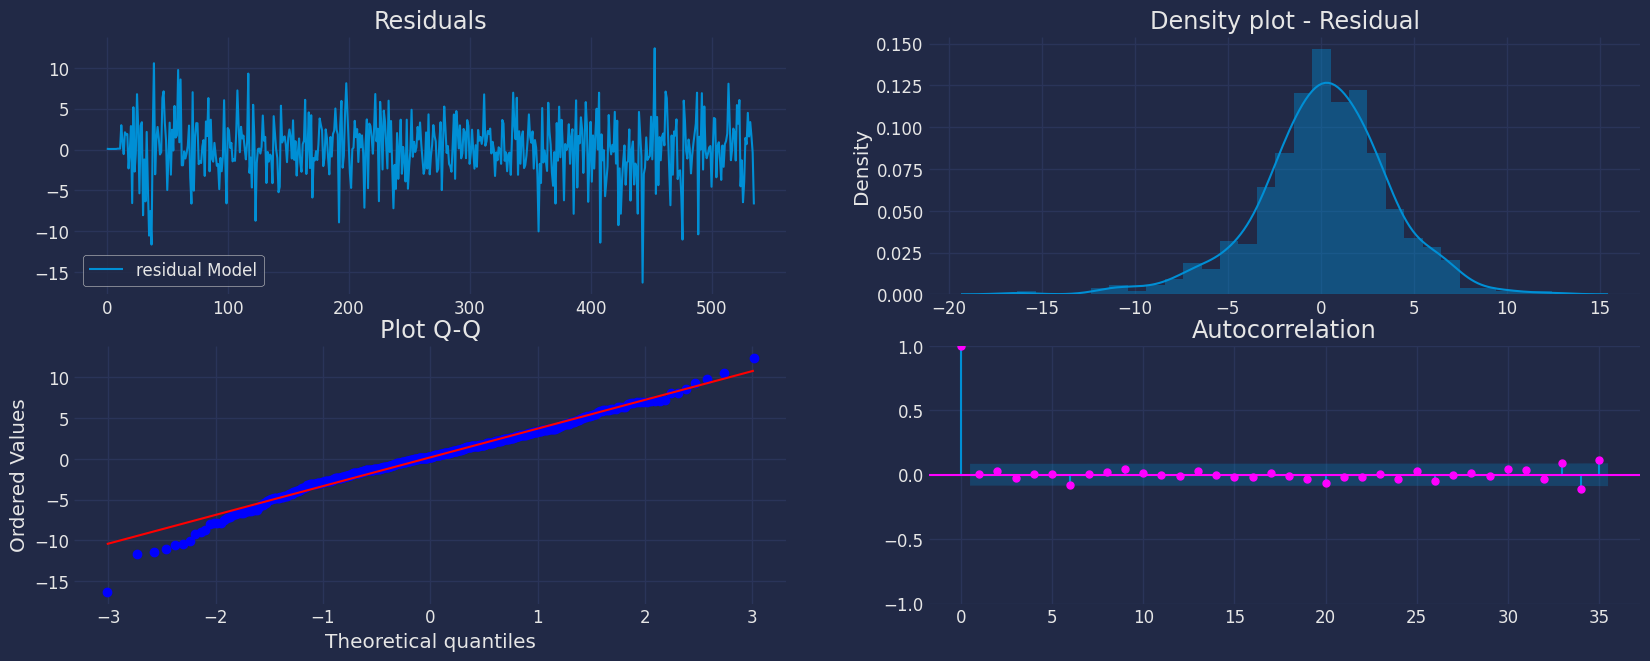

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

To generate forecasts we only have to use the predict method specifying the forecast horizon (h). In addition, to calculate prediction intervals associated to the forecasts, we can include the parameter level that receives a list of levels of the prediction intervals we want to build. In this case we will only calculate the 90% forecast interval (level=[90]).

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [ ]:
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon, fitted=True)
Y_hat_df.head()

,unique_id,ds,AutoARIMA
0,1,2016-09-01,111.235874
1,1,2016-10-01,124.948376
2,1,2016-11-01,125.401639
3,1,2016-12-01,123.854826
4,1,2017-01-01,110.439451


In [ ]:
values=sf.forecast_fitted_values()
values

,unique_id,ds,y,AutoARIMA
0,1,1972-01-01,85.6945,85.608806
1,1,1972-02-01,71.8200,71.748180
2,1,1972-03-01,66.0229,65.956878
...,...,...,...,...
533,1,2016-06-01,102.4044,100.788914
534,1,2016-07-01,102.9512,103.345485
535,1,2016-08-01,104.6977,111.431248


Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(df=Y_train_df, h=12, level=[95])

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,1,2016-09-01,111.235874,104.140621,118.331128
1,1,2016-10-01,124.948376,116.244661,133.652090
2,1,2016-11-01,125.401639,115.882093,134.921185
...,...,...,...,...,...
9,1,2017-06-01,98.304446,85.884572,110.724320
10,1,2017-07-01,99.630306,87.032356,112.228256
11,1,2017-08-01,105.426708,92.639159,118.214258


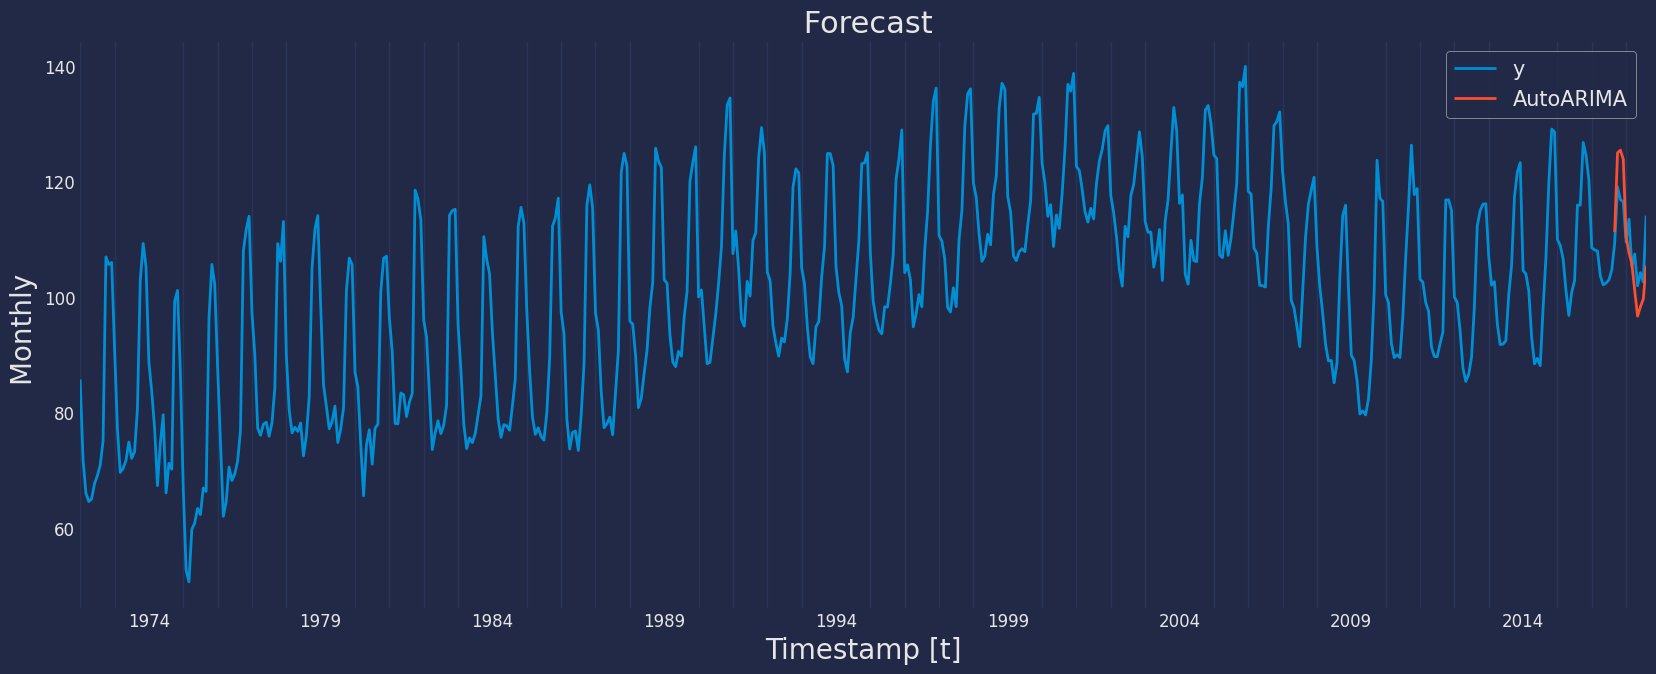

In [ ]:
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=12)

,unique_id,ds,AutoARIMA
0,1,2016-09-01,111.235874
1,1,2016-10-01,124.948376
2,1,2016-11-01,125.401639
...,...,...,...
9,1,2017-06-01,98.304446
10,1,2017-07-01,99.630306
11,1,2017-08-01,105.426708


In [ ]:
forecast_df = sf.predict(h=12, level = [80, 95])
forecast_df

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
0,1,2016-09-01,111.235874,104.140621,106.596537,115.875211,118.331128
1,1,2016-10-01,124.948376,116.244661,119.257323,130.639429,133.652090
2,1,2016-11-01,125.401639,115.882093,119.177142,131.626136,134.921185
...,...,...,...,...,...,...,...
9,1,2017-06-01,98.304446,85.884572,90.183527,106.425365,110.724320
10,1,2017-07-01,99.630306,87.032356,91.392949,107.867663,112.228256
11,1,2017-08-01,105.426708,92.639159,97.065379,113.788038,118.214258


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
df_plot=pd.concat([df, forecast_df]).set_index('ds').tail(220)
df_plot

,y,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,,,
2000-05-01,108.7202,1,NaN,NaN,NaN,NaN,NaN
2000-06-01,114.2071,1,NaN,NaN,NaN,NaN,NaN
2000-07-01,111.8737,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-06-01,NaN,1,98.304446,85.884572,90.183527,106.425365,110.724320
2017-07-01,NaN,1,99.630306,87.032356,91.392949,107.867663,112.228256
2017-08-01,NaN,1,105.426708,92.639159,97.065379,113.788038,118.214258


Now let's visualize the result of our forecast and the historical data of our time series, also let's draw the confidence interval that we have obtained when making the prediction with 95% confidence.

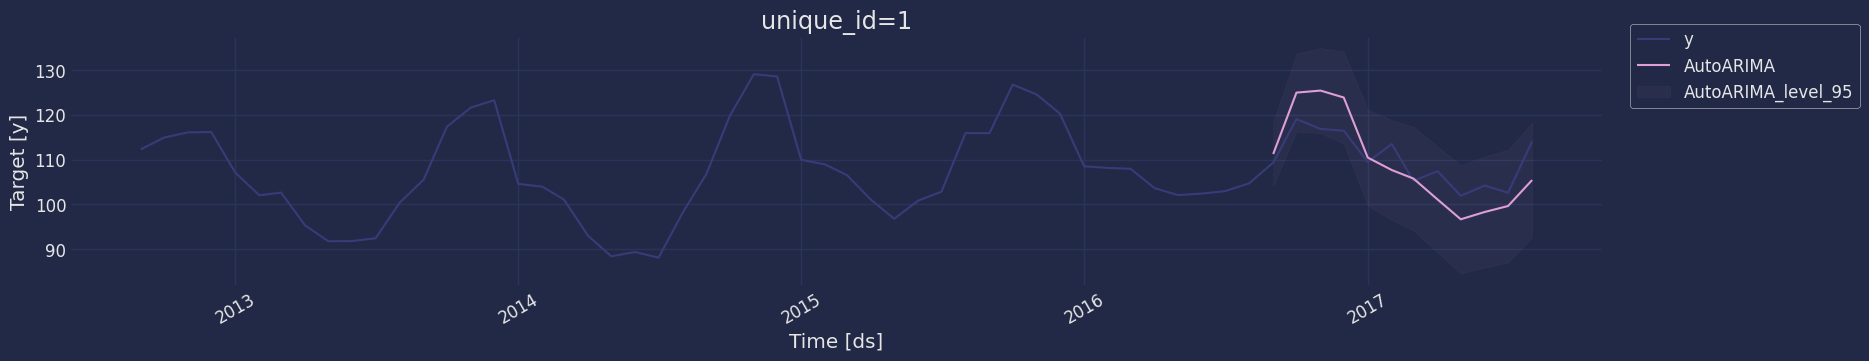

In [ ]:
sf.plot(df, forecast_df, level=[95], max_insample_length=12 * 5)

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=Y_train_df,
                                         h=12,
                                         step_size=12,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` series identifier
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df.head()

,unique_id,ds,cutoff,y,AutoARIMA
0,1,2011-09-01,2011-08-01,93.9062,105.235606
1,1,2011-10-01,2011-08-01,116.7634,118.739813
2,1,2011-11-01,2011-08-01,116.8258,114.572924
3,1,2011-12-01,2011-08-01,114.9563,114.991219
4,1,2012-01-01,2011-08-01,99.9662,100.133142


## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    Y_test_df.merge(Y_hat_df),
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=season_length), ufl.rmse, ufl.smape],
    train_df=Y_train_df,
)

,unique_id,metric,AutoARIMA
0,1,mae,5.012894
1,1,mape,0.045046
2,1,mase,0.967601
3,1,rmse,5.680362
4,1,smape,0.022673


## References <a class="anchor" id="references"></a>


1. [Nixtla AutoARIMA API](../../models#class-autoarima)
2. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).
